### Assignment - 1

#### 1. Load and Inspect the CMAPSS Dataset
Task:
- Write Python code to load the raw `train_FD001.txt` dataset for CMAPSS using Pandas, assign appropriate column names, and display the shape, data types, and first 5 rows of the DataFrame.
- Expected Output: DataFrame shape, info, and sample rows.

Use the link to download the dataset:
https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data

In [2]:
import pandas as pd
import os

file_path = 'Data/train_FD001.txt'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file was not found: {file_path}")

col_names = [
    "unit_number", "time_in_cycles",
    "operational_setting_1", "operational_setting_2", "operational_setting_3"
] + [f"sensor_{i}" for i in range(1, 22)]

df = pd.read_csv(file_path, sep=r"\s+", header=None, names=col_names)

print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nFirst 5 Rows:\n", df.head())


Dataset Shape: (20631, 26)

Data Types:
 unit_number                int64
time_in_cycles             int64
operational_setting_1    float64
operational_setting_2    float64
operational_setting_3    float64
sensor_1                 float64
sensor_2                 float64
sensor_3                 float64
sensor_4                 float64
sensor_5                 float64
sensor_6                 float64
sensor_7                 float64
sensor_8                 float64
sensor_9                 float64
sensor_10                float64
sensor_11                float64
sensor_12                float64
sensor_13                float64
sensor_14                float64
sensor_15                float64
sensor_16                float64
sensor_17                  int64
sensor_18                  int64
sensor_19                float64
sensor_20                float64
sensor_21                float64
dtype: object

First 5 Rows:
    unit_number  time_in_cycles  operational_setting_1  operational_sett

#### 2. Visualize Sensor Distributions and Identify Missing Values
Task:
- Using the loaded dataset (or the cleaned version), visualize the distribution of values for any three sensor columns with histograms, and check for missing values in all columns.
- Expected Output: Three histogram plots and a summary/report on missing values per column.

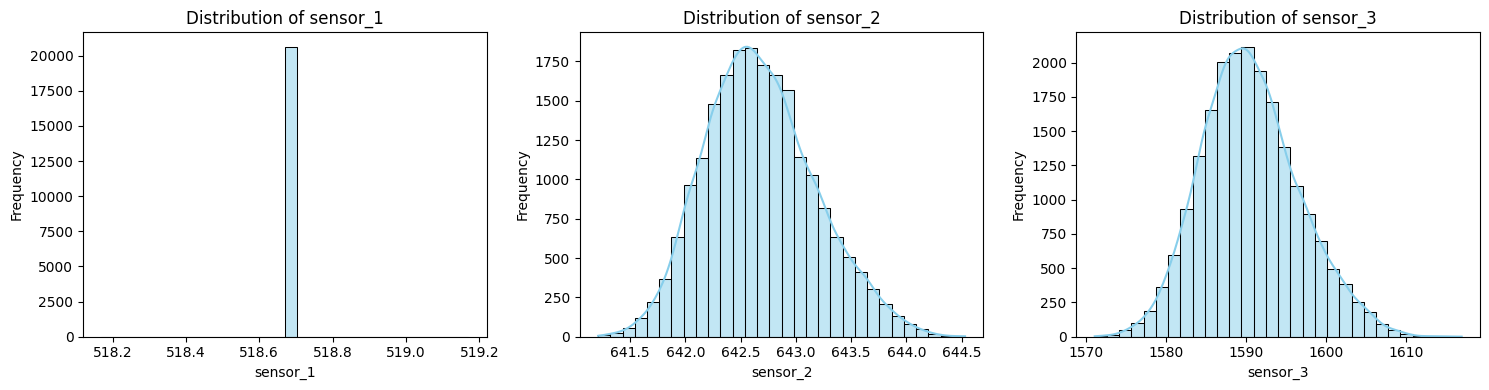

Missing Values per Column:

unit_number              0
time_in_cycles           0
operational_setting_1    0
operational_setting_2    0
operational_setting_3    0
sensor_1                 0
sensor_2                 0
sensor_3                 0
sensor_4                 0
sensor_5                 0
sensor_6                 0
sensor_7                 0
sensor_8                 0
sensor_9                 0
sensor_10                0
sensor_11                0
sensor_12                0
sensor_13                0
sensor_14                0
sensor_15                0
sensor_16                0
sensor_17                0
sensor_18                0
sensor_19                0
sensor_20                0
sensor_21                0
dtype: int64


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sensors_to_plot = ['sensor_1', 'sensor_2', 'sensor_3']

plt.figure(figsize=(15, 4))
for i, sensor in enumerate(sensors_to_plot, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[sensor], bins=30, kde=True, color='skyblue')
    plt.title(f'Distribution of {sensor}')
    plt.xlabel(sensor)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

missing_values = df.isnull().sum()
print("Missing Values per Column:\n")
print(missing_values)


#### 3. Feature Engineering – Aggregation and Rolling Statistics
Task:
- For a selected sensor (e.g., `sensor_2`), compute and append to the DataFrame:
  - The mean and standard deviation of `sensor_2` by each `engine_id`

  - The rolling mean (window size=5) for each engine’s `sensor_2` readings
- Expected Output: Show a few sample rows with these new features.

In [4]:
sensor = 'sensor_2'

df[f'{sensor}_mean_by_unit'] = df.groupby('unit_number')[sensor].transform('mean')
df[f'{sensor}_std_by_unit'] = df.groupby('unit_number')[sensor].transform('std')
df[f'{sensor}_rolling_mean_5'] = df.groupby('unit_number')[sensor].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

df.head(10)


,unit_number,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_2_mean_by_unit,sensor_2_std_by_unit,sensor_2_rolling_mean_5
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,642.621042,0.486795,641.820000
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,642.621042,0.486795,641.985000
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,642.621042,0.486795,642.106667
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,642.621042,0.486795,642.167500
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,642.621042,0.486795,642.208000
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,8.4108,0.03,391,2388,100.0,38.98,23.3669,642.621042,0.486795,642.264000
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,8.3974,0.03,392,2388,100.0,39.10,23.3774,642.621042,0.486795,642.330000
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,8.4076,0.03,391,2388,100.0,38.97,23.3106,642.621042,0.486795,642.372000
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,8.3728,0.03,392,2388,100.0,39.05,23.4066,642.621042,0.486795,642.326000
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,8.4286,0.03,393,2388,100.0,38.95,23.4694,642.621042,0.486795,642.194000


#### 4. Data Normalization
Task:
- Normalize all sensor columns in the DataFrame using `StandardScaler` from `scikit-learn` (zero mean, unit variance) and create a new DataFrame, maintaining the original `engine_id` and `cycle` columns.
- Expected Output: Head of the normalized DataFrame and a check that means are close to zero, std are close to one.

In [5]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

sensors = [f'sensor_{i}' for i in range(1, 22)]
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df[sensors])

df_scaled = pd.DataFrame(scaled_values, columns=sensors)
df_scaled['unit_number'] = df['unit_number']
df_scaled['time_in_cycles'] = df['time_in_cycles']

print(df_scaled.head())
print("\nMean values of sensors:\n", df_scaled[sensors].mean().round(6))
print("\nStd values of sensors:\n", df_scaled[sensors].std().round(6))


   sensor_1  sensor_2  sensor_3  sensor_4      sensor_5  sensor_6  sensor_7  \
0       0.0 -1.721725 -0.134255 -0.925936 -1.776357e-15  0.141683  1.121141   
1       0.0 -1.061780  0.211528 -0.643726 -1.776357e-15  0.141683  0.431930   
2       0.0 -0.661813 -0.413166 -0.525953 -1.776357e-15  0.141683  1.008155   
3       0.0 -0.661813 -1.261314 -0.784831 -1.776357e-15  0.141683  1.222827   
4       0.0 -0.621816 -1.251528 -0.301518 -1.776357e-15  0.141683  0.714393   

   sensor_8  sensor_9  sensor_10  ...  sensor_14  sensor_15     sensor_16  \
0 -0.516338 -0.862813        0.0  ...  -0.269071  -0.603816 -1.387779e-17   
1 -0.798093 -0.958818        0.0  ...  -0.642845  -0.275852 -1.387779e-17   
2 -0.234584 -0.557139        0.0  ...  -0.551629  -0.649144 -1.387779e-17   
3  0.188048 -0.713826        0.0  ...  -0.520176  -1.971665 -1.387779e-17   
4 -0.516338 -0.457059        0.0  ...  -0.521748  -0.339845 -1.387779e-17   

   sensor_17  sensor_18  sensor_19  sensor_20  sensor_21  unit

#### 5. Rolling Window Sequence Generation
Task:
- Write a function to generate rolling window sequences of length 30 for the sensors of each engine. Save the resulting 3D NumPy array (num_sequences, window_size, num_features), and save the corresponding engine_id and cycle identifier lists as CSV files. Print the shape of the resulting sequence array and contents of the first entry.
- Expected Output: Array shape, example content, and confirmation of successful file saves.